# **1. Starting Setup**




In [1]:
!pip install \
  numpy==1.26.4 \
  pandas==2.1.4 \
  pyarrow==14.0.2 \
  datasets==2.18.0 \
  langchain==0.2.17 \
  langchain-core==0.2.43 \
  langchain-community==0.2.17 \
  langchain-text-splitters==0.2.4


In [2]:
import numpy as np
import pandas as pd
import pyarrow as pa
from datasets import Dataset

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("pyarrow:", pa.__version__)


numpy: 1.26.4
pandas: 2.1.4
pyarrow: 14.0.2


In [3]:
!pip install -q "transformers>=4.40.0" datasets accelerate bitsandbytes sentencepiece protobuf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 17.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import pyarrow as pa
from datasets import Dataset

print(np.__version__)
print(pd.__version__)
print(pa.__version__)


1.26.4
2.1.4
14.0.2


In [5]:
import torch
import re
from tqdm import tqdm
from pathlib import Path
from datasets import Dataset

## 1.2 Setting runtime

In [6]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ No GPU. Go to Runtime → Change runtime type → set GPU.")

CUDA available: True
GPU: Tesla T4


## 1.3 Import Dataset

In [7]:
!git clone https://github.com/sooo66/semeval2026-task12-dataset.git
!ls semeval2026-task12-dataset

Cloning into 'semeval2026-task12-dataset'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 63 (delta 27), reused 46 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 6.71 MiB | 11.83 MiB/s, done.
Resolving deltas: 100% (27/27), done.
dev_data   sample_data			   test_data
README.md  semeval2026-task12-dataset-old  train_data


## 1.4 Constants definition

In [8]:


# Root of the cloned repo in Colab
DATA_ROOT = Path("/content/semeval2026-task12-dataset")

# Choose the split you want to evaluate: "train_data", "dev_data", or "sample_data"
SPLIT = "dev_data"  # you can change this

QUESTIONS_FILE = DATA_ROOT / SPLIT / "questions.jsonl"
DOCS_FILE      = DATA_ROOT / SPLIT / "docs.json"

print("Questions file:", QUESTIONS_FILE)
print("Docs file:", DOCS_FILE)

Questions file: /content/semeval2026-task12-dataset/dev_data/questions.jsonl
Docs file: /content/semeval2026-task12-dataset/dev_data/docs.json


 ## 1.5 Import Repository and load dataset

In [9]:

!git clone https://github.com/irenebartolini02/LLM-abductive-event-reasoning.git
%cd LLM-abductive-event-reasoning

Cloning into 'LLM-abductive-event-reasoning'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 171 (delta 87), reused 115 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (171/171), 5.41 MiB | 8.61 MiB/s, done.
Resolving deltas: 100% (87/87), done.
/content/LLM-abductive-event-reasoning


In [10]:
from utils.data_loader import load_jsonl, load_json, index_docs_by_topic

questions = load_jsonl(QUESTIONS_FILE)
docs = load_json(DOCS_FILE)
docs_by_topic = index_docs_by_topic(docs)

print("Num questions:", len(questions))
print("Num doc groups:", len(docs_by_topic))
print("Example question keys:", questions[0].keys())

Num questions: 400
Num doc groups: 36
Example question keys: dict_keys(['topic_id', 'id', 'target_event', 'option_A', 'option_B', 'option_C', 'option_D', 'golden_answer'])


## **1.6. Loading Model**



In [11]:
!pip install -U bitsandbytes

In [12]:

from utils.model_utils import load_model

# set yor model name
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"


model, tokenizer= load_model(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Model loaded on: cuda:0


# **2. RAG implementation**

## **Causal RAG setup libraries**

In [13]:
!pip install langchain-experimental==0.0.64


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 8.1 MB/s eta 0:00:00


In [14]:
!pip install langchain-huggingface==0.0.3


In [15]:
!pip install rank_bm25

In [16]:
from rag.CausalRAG import CausalRAG

## IDEA GENERALE:
0. tramite preprocessing generare il grafo di ogni topic_id nel dataset (va fatto solo la prima volta [BUILDER] le successive basterà fare load  )

---------------------------------------------------------
CAUSALRAG:
1. cercare i nodi più simili a causa (Option_x) e effetto (target_event)
2. cercare relazioni causali dei nodi selezionati navigando il grafo
3. generare un riassunto coerente e coeso [SYNTHETIZER]

-----------------------------------------------------------
4. verificare dato il contesto selezionato se l'opzione ha causato il target event [VERIFIER]


## 0. Creazione del grafo - RUNNARE SOLO SE NECESSARIO




### 0.1. Setup, divide doc in chuncks

**dividere i documenti in chunk e scegliere la dimensione**

In [17]:

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# Strategia di Chunking: Recursive è meglio perché rispetta i paragrafi
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200, # Sovrapposizione per non perdere i nessi causali tra i pezzi
    separators=["\n\n", "\n", ".", " "]
)



In [18]:

!pip install json-repair
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 94.6 MB/s eta 0:00:00


**Modello ultra veloce per chunk embeddings**

In [19]:
from langchain_community.embeddings import HuggingFaceEmbeddings

# OPZIONE ULTRA-VELOCE:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-MiniLM-L3-v2"  # 17M parametri, 3x più veloce
)

/tmp/ipython-input-2935306677.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

**creare vocabolario chunks**

In [21]:
from langchain_core.documents import Document
from tqdm import tqdm

# Inizializza dizionario
vector_db_per_topic = dict()

print("Creating vector databases with chunk indices...")

for topic_id, docs_list in tqdm(docs_by_topic.items(), desc="Processing topics"):
    all_chunks = []

    # Per ogni documento nel topic
    for doc_idx, doc_dict in enumerate(docs_list):
        # 1. Crea Document
        doc = Document(
            page_content=doc_dict.get('content', ''),
            metadata={'title': doc_dict.get('title', '')}
        )

        # 2. Splitta in chunks
        chunks = text_splitter.split_documents([doc])

        # 3. ✓ AGGIUNGI METADATA con indici
        for chunk_idx, chunk in enumerate(chunks):
            chunk.metadata.update({
                'topic_id': topic_id,
                'doc_id': doc_idx,              # Posizione nel topic
                'chunk_index': chunk_idx,       # Posizione nel documento
                'total_chunks': len(chunks),
                'global_index': len(all_chunks), # Indice globale nel topic
                'title': doc_dict.get('title', '')
            })
            all_chunks.append(chunk)

    # 4. Crea vector DB per il topic
    if all_chunks:
        vector_db_per_topic[topic_id] = FAISS.from_documents(all_chunks, embeddings)
        print(f"  Topic {topic_id}: {len(all_chunks)} chunks from {len(docs_list)} docs")
    else:
        print(f"  ⚠ Topic {topic_id}: No chunks created")

print(f"\n✓ Created {len(vector_db_per_topic)} vector databases")

Creating vector databases with chunk indices...


Processing topics:   3%|▎         | 1/36 [00:00<00:15,  2.26it/s]

  Topic 1: 154 chunks from 17 docs


Processing topics:   6%|▌         | 2/36 [00:00<00:13,  2.59it/s]

  Topic 3: 131 chunks from 19 docs


Processing topics:   8%|▊         | 3/36 [00:01<00:11,  2.76it/s]

  Topic 4: 131 chunks from 15 docs


Processing topics:  14%|█▍        | 5/36 [00:01<00:09,  3.41it/s]

  Topic 2: 229 chunks from 16 docs
  Topic 5: 128 chunks from 16 docs


Processing topics:  17%|█▋        | 6/36 [00:01<00:08,  3.75it/s]

  Topic 6: 175 chunks from 16 docs
  Topic 7: 68 chunks from 14 docs


Processing topics:  22%|██▏       | 8/36 [00:02<00:05,  5.15it/s]

  Topic 8: 135 chunks from 16 docs


Processing topics:  28%|██▊       | 10/36 [00:02<00:04,  5.23it/s]

  Topic 9: 184 chunks from 18 docs
  Topic 10: 155 chunks from 17 docs


Processing topics:  31%|███       | 11/36 [00:03<00:07,  3.47it/s]

  Topic 11: 502 chunks from 22 docs


Processing topics:  33%|███▎      | 12/36 [00:03<00:07,  3.08it/s]

  Topic 12: 387 chunks from 25 docs


Processing topics:  36%|███▌      | 13/36 [00:03<00:06,  3.31it/s]

  Topic 13: 241 chunks from 21 docs


Processing topics:  39%|███▉      | 14/36 [00:04<00:07,  3.01it/s]

  Topic 14: 419 chunks from 17 docs


Processing topics:  42%|████▏     | 15/36 [00:04<00:07,  2.96it/s]

  Topic 15: 311 chunks from 31 docs


Processing topics:  44%|████▍     | 16/36 [00:04<00:07,  2.70it/s]

  Topic 16: 231 chunks from 18 docs


Processing topics:  47%|████▋     | 17/36 [00:05<00:07,  2.54it/s]

  Topic 17: 155 chunks from 22 docs


Processing topics:  50%|█████     | 18/36 [00:06<00:10,  1.72it/s]

  Topic 18: 274 chunks from 24 docs


Processing topics:  53%|█████▎    | 19/36 [00:06<00:09,  1.72it/s]

  Topic 19: 148 chunks from 24 docs


Processing topics:  56%|█████▌    | 20/36 [00:07<00:11,  1.45it/s]

  Topic 20: 306 chunks from 25 docs


Processing topics:  58%|█████▊    | 21/36 [00:08<00:10,  1.46it/s]

  Topic 21: 228 chunks from 29 docs


Processing topics:  61%|██████    | 22/36 [00:08<00:07,  1.79it/s]

  Topic 22: 104 chunks from 20 docs


Processing topics:  64%|██████▍   | 23/36 [00:09<00:07,  1.73it/s]

  Topic 23: 348 chunks from 24 docs


Processing topics:  67%|██████▋   | 24/36 [00:09<00:06,  1.96it/s]

  Topic 24: 122 chunks from 28 docs


Processing topics:  69%|██████▉   | 25/36 [00:10<00:04,  2.33it/s]

  Topic 25: 154 chunks from 18 docs


Processing topics:  75%|███████▌  | 27/36 [00:10<00:03,  2.91it/s]

  Topic 26: 290 chunks from 23 docs
  Topic 27: 177 chunks from 25 docs


Processing topics:  78%|███████▊  | 28/36 [00:10<00:02,  3.27it/s]

  Topic 28: 183 chunks from 25 docs


Processing topics:  81%|████████  | 29/36 [00:11<00:01,  3.52it/s]

  Topic 29: 221 chunks from 23 docs


Processing topics:  83%|████████▎ | 30/36 [00:11<00:02,  2.37it/s]

  Topic 30: 567 chunks from 25 docs


Processing topics:  86%|████████▌ | 31/36 [00:12<00:01,  2.59it/s]

  Topic 31: 282 chunks from 27 docs


Processing topics:  92%|█████████▏| 33/36 [00:12<00:00,  3.45it/s]

  Topic 32: 206 chunks from 27 docs
  Topic 33: 167 chunks from 18 docs


Processing topics:  97%|█████████▋| 35/36 [00:12<00:00,  4.22it/s]

  Topic 34: 251 chunks from 24 docs
  Topic 35: 118 chunks from 23 docs


Processing topics: 100%|██████████| 36/36 [00:13<00:00,  2.76it/s]

  Topic 36: 145 chunks from 23 docs

✓ Created 36 vector databases


### 0.2 creare causal rag di un topic

In [22]:
#NON RUNNARE
# SE NON VUOI RICREARE IL GRAFO PER IL TOPIC 1, scaricalo direttamente da quello salvato
import json
topic_id=36
vector_db = vector_db_per_topic.get(topic_id)

if vector_db:
    all_dict = vector_db.docstore._dict
    chunks_from_db = list(all_dict.values())
    causal_rag_id_1 = CausalRAG(model, tokenizer, k=5, s=5)
    # Ora puoi passarli al CausalRAG
    causal_rag_id_1.index_documents( [doc for doc in chunks_from_db])

Device set to use cuda:0
/content/LLM-abductive-event-reasoning/rag/CausalRAG.py:43: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  self.llm = HuggingFacePipeline(pipeline=pipe)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Indexing 145 chunks...


Graph Extraction:   4%|▍         | 6/145 [00:31<19:42,  8.50s/chunk]

KeyboardInterrupt: 

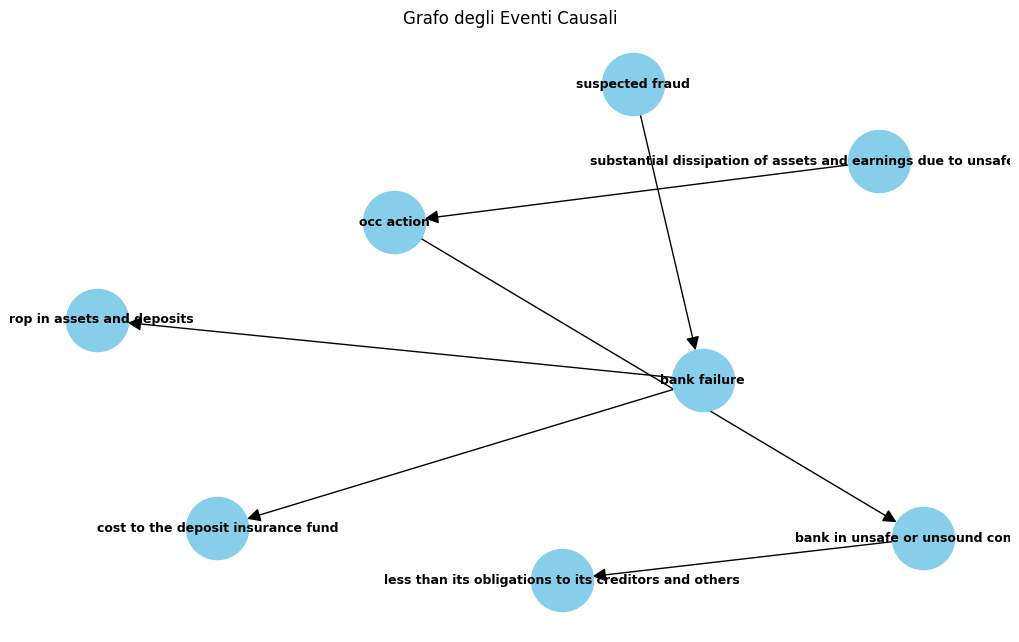

In [23]:
causal_rag_id_1.visualize()

In [24]:
import shutil
import os
import pickle
causal_rag_id_1.save_causal_rag(1, folder="causal_data")

✓ Dati salvati correttamente per il topic 1


In [ ]:
import shutil
import os

# Definisci il percorso della cartella da zippare e il nome del file finale
folder_to_zip = '/content/LLM-abductive-event-reasoning/causal_data'
output_filename = '/content/causal_rag_dataset'

# Crea il file zip
shutil.make_archive(output_filename, 'zip', folder_to_zip)

print(f"File {output_filename}.zip creato con successo! ora puoi scaricarlo manualmente")

File /content/causal_rag_dataset.zip creato con successo! ora puoi scaricarlo manualmente


# Experiments

## 0. unzip uploaded causalGraph

In [26]:
# Nota bene è necessario caricare manualmente il file zip contenente il gravo per testare
!unzip '/content/causal_dataset.zip' -d /content

Archive:  /content/causal_dataset.zip
   creating: /content/causal_dataset/
   creating: /content/causal_dataset/topic_1/
   creating: /content/causal_dataset/topic_1/faiss_index/
  inflating: /content/causal_dataset/topic_1/faiss_index/index.faiss  
  inflating: /content/causal_dataset/topic_1/faiss_index/index.pkl  
  inflating: /content/causal_dataset/topic_1/graph.pkl  
  inflating: /content/causal_dataset/topic_1/node_map.pkl  
   creating: /content/causal_dataset/topic_3/
   creating: /content/causal_dataset/topic_3/faiss_index/
  inflating: /content/causal_dataset/topic_3/faiss_index/index.faiss  
  inflating: /content/causal_dataset/topic_3/faiss_index/index.pkl  
  inflating: /content/causal_dataset/topic_3/graph.pkl  
  inflating: /content/causal_dataset/topic_3/node_map.pkl  
   creating: /content/causal_dataset/topic_4/
   creating: /content/causal_dataset/topic_4/faiss_index/
  inflating: /content/causal_dataset/topic_4/faiss_index/index.faiss  
  inflating: /content/causa

## 4. Verify

In [25]:
# VERIFIER

def format_qwen_prompt_binary(tokenizer, entry, context_text, option_label):
    """
    Formatta il prompt per una singola opzione in modalità binaria (TRUE/FALSE).

    Args:
        tokenizer: Il tokenizer del modello Qwen.
        SYSTEM_PROMPT: Il prompt di sistema "Causal Reasoning Verifier" che abbiamo scritto.
        entry: L'elemento del dataset (contiene 'target_event' e le opzioni).
        context_text: Il contesto recuperato (idealmente specifico per quell'opzione).
        option_label: La lettera dell'opzione da valutare (A, B, C o D).
    """

    event = entry.get('target_event')

    # Recuperiamo il testo dell'opzione specifica (es. entry['option_A'])
    option_text = entry.get(f'option_{option_label}')
    system_content = """
      You are a Causal Auditor. Your goal is to distinguish between direct/indirect causation and mere background context.

      CRITERIA FOR TRUE:
      - TRANSITIVE PROOF: If the context shows a step-by-step chain (A -> B -> C), then A is a valid cause for C.
      - EVENT ORIGIN: If the Target Event (e.g., a petition) is a direct consequence of the OUTCOME of the Candidate Cause (e.g., the referendum results), answer TRUE.
      - ACTIONABLE LINKS: Even if the context uses "paved the way", look at the next sentences. If they describe a clear transmission of influence, it is TRUE.

      CRITERIA FOR FALSE:
      - THE COUNTERFACTUAL TEST: If the Candidate Cause had NOT happened, would the Target Event still have occurred?

      Answer ONLY with TRUE or FALSE."""

    user_content = f"""CONTEXT: {context_text}
QUESTION: Based on the context above, can "{option_text}" be considered a cause or a significant contributing factor to "{event}"?
ANSWER (TRUE/FALSE):"""

    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": user_content}
    ]

    # Utilizziamo l'apply_chat_template del tokenizer per mantenere il formato <|im_start|>
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    return prompt

def clean_verifier_response(raw_response: str) -> str:
    """Estrae TRUE o FALSE ignorando spiegazioni o spazi bianchi."""
    # Convertiamo tutto in maiuscolo per sicurezza
    text = raw_response.upper().strip()

    # Cerchiamo se la stringa INIZIA con TRUE o FALSE (caso più comune)
    if text.startswith("TRUE"):
        return "TRUE"
    if text.startswith("FALSE"):
        return "FALSE"

    # Se il modello ha scritto "The answer is TRUE", cerchiamo la parola ovunque
    if "TRUE" in text:
        return "TRUE"
    if "FALSE" in text:
        return "FALSE"

    return "FALSE" # Default in caso di incertezza

# EVALUATION

In [30]:
import gc   # garbage collector
from utils.model_utils import format_qwen_prompt
from utils.output_utils import clean_response, calculate_score, print_metrics
import json
import langchain.globals
import os
import pickle
from rag.CausalRAG import generate_causal_summary

WRONG_ANSWERS_FILE = "/content/WRONG.jsonl"
RIGHT_ANSWERS_FILE = "/content/RIGHT.jsonl"

total_score = 0
count = 0
errors = 0
results=[]
processed_uuids=set()

#se esistono già file di log li elimino
if os.path.exists(WRONG_ANSWERS_FILE):
  os.remove(WRONG_ANSWERS_FILE)
if os.path.exists(RIGHT_ANSWERS_FILE):
  os.remove(RIGHT_ANSWERS_FILE)
i=1
# we use tqdm to see the progress bar
questions_id = [q for q in questions if q.get('topic_id')==1]
print(f"Starting evaluation on {len(questions_id)} questions...")
for entry in tqdm(questions_id):
    # Inizializziamo a None per evitare errori nel blocco 'del'
    inputs = None
    outputs = None

    try:
        topic_id = entry['topic_id']
        #question_uuid = entry['uuid']
        golden_ans = entry['golden_answer']
        target_event = entry['target_event']
        #RAG

        print(f"Event {target_event}")
        #all chunks for item id
        vector_db = vector_db_per_topic.get(topic_id, [])

        all_prompts_responses={}
        none_of_the_others= None
        pred_set= set()

        #load preprocessed causalRAG
        causal_rag= CausalRAG(model, tokenizer, k=3, s=5)
        causal_rag.load_causal_rag(topic_id=topic_id, folder="/content/causal_dataset")
        #causal_rag= causal_rag_fused
        for op_label in ['A', 'B', 'C', 'D']:

          option_text= entry[f'option_{op_label}']

          # none of the others detection
          if "none of the others are correct causes" in option_text.lower().strip():
            none_of_the_others= op_label
            continue

          # select 1 more util chuncks

          cause= option_text
          effect=target_event
          context_text= generate_causal_summary(causal_rag,  cause, effect)


          # Prompt binary------------------------------------------
          prompt_inference= format_qwen_prompt_binary(tokenizer, entry, context_text , op_label)

          # 2. Tokenization
          inputs = tokenizer(prompt_inference, return_tensors="pt").to(model.device)
          # 3. Generation (Greedy decoding for reproducibility)
          with torch.no_grad():
              outputs = model.generate(
              **inputs,
              max_new_tokens=10,
              do_sample=False,      # Determinism
              temperature=0.0,
              pad_token_id=tokenizer.eos_token_id
          )
          # 4. Decoding e Cleaning
          # Cutting the input prompt -> the response of the model also contains the input prompt we provided
          generated_ids = outputs[0][inputs.input_ids.shape[1]:]
          # Extract true or false
          raw_response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
          clean_response= clean_verifier_response(raw_response)
          all_prompts_responses[op_label]= {
                                            'option': cause,
                                            'context': context_text,
                                            'response': clean_response
                                            }

          if clean_response.upper().strip() == "TRUE":
            pred_set.add(op_label)

        # outise the loop
        if pred_set == set():
          if none_of_the_others:
            pred_set.add(none_of_the_others)
          else:
            print("no answer")


      # 5. Calculate score
        score = calculate_score(pred_set, golden_ans)
        print("Predicted: "+ str(pred_set) + "\t Gold: "+ str(golden_ans) + "\tScore: "+str(score))
        if score!=1:
          # save wrong answer
          obj = {}
          with open(WRONG_ANSWERS_FILE, 'a', encoding='utf-8') as f:
            obj = all_prompts_responses
            obj["event"]= target_event
            obj["gold"]= golden_ans
            obj["pred"]= list(pred_set)
            f.write( json.dumps(obj, indent=4))
        else:
            obj = {}
            with open(RIGHT_ANSWERS_FILE, 'a', encoding='utf-8') as f:
              obj = all_prompts_responses
              obj["event"]= target_event
              obj["gold"]= golden_ans
              obj["pred"]= list(pred_set)
              f.write( json.dumps(obj, indent=4))


        # We prepare the result object (a list of result_item, which is the following dictionare)
        result_item = {
            #"uuid": question_uuid,
            "topic_id": topic_id,
            "golden_raw": golden_ans,
            "prediction_raw": raw_response,
            "prediction_set": list(pred_set),
            "score": score
        }


        # Updating variables in memory
        results.append(result_item)
        #processed_uuids.add(question_uuid)
        total_score += score
        count += 1

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"UUID:{entry['uuid']} process skipped due to OOM")
            errors += 1
            continue
        else:
            print(f"Errore generico: {e}")
            continue
    finally:
        # Questo blocco viene eseguito SEMPRE, sia se il codice va bene sia se crasha
        if inputs is not None: inputs = None  # Reassign to None instead of del
        if outputs is not None: outputs = None # Reassign to None instead of del
        torch.cuda.empty_cache()
        gc.collect()

Starting evaluation on 12 questions...



  0%|          | 0/12 [00:00<?, ?it/s]Device set to use cuda:0


Event The United Kingdom held a referendum on June 23.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.


/content/LLM-abductive-event-reasoning/rag/CausalRAG.py:365: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  result_docs = self.bm25_retriever.get_relevant_documents(query)


Predicted: {'A', 'C', 'B'}	 Gold: A,B,C	Score: 1.0


Graph Extraction:   4%|▍         | 6/145 [06:13<2:24:12, 62.25s/chunk]

  8%|▊         | 1/12 [01:36<17:40, 96.37s/it]Device set to use cuda:0


Event Global markets plunged following the Brexit vote.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'A', 'C'}	 Gold: C	Score: 0.0



 17%|█▋        | 2/12 [03:58<20:33, 123.34s/it]Device set to use cuda:0


Event Sinn Fein called for a referendum on Irish unity.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'A', 'C', 'B'}	 Gold: C,D	Score: 0.0



 25%|██▌       | 3/12 [06:30<20:27, 136.44s/it]Device set to use cuda:0


Event The British pound plunged in value.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'A', 'C', 'D'}	 Gold: A	Score: 0.0



 33%|███▎      | 4/12 [08:20<16:48, 126.06s/it]Device set to use cuda:0


Event The British pound plunged in value.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'A', 'B', 'D'}	 Gold: A	Score: 0.0



 42%|████▏     | 5/12 [09:26<12:09, 104.26s/it]Device set to use cuda:0


Event Over three million Brits called for a do-over.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'C', 'D'}	 Gold: C,D	Score: 1.0



 50%|█████     | 6/12 [10:28<08:58, 89.79s/it] Device set to use cuda:0


Event Global markets plunged following the Brexit vote.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'B', 'D'}	 Gold: B,D	Score: 1.0



 58%|█████▊    | 7/12 [11:37<06:55, 83.09s/it]Device set to use cuda:0


Event Over three million Brits called for a do-over.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'C', 'B'}	 Gold: C	Score: 0.0



 67%|██████▋   | 8/12 [12:47<05:15, 78.88s/it]Device set to use cuda:0


Event Over three million Brits called for a do-over.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'A', 'C', 'B'}	 Gold: A,C	Score: 0.0



 75%|███████▌  | 9/12 [13:39<03:31, 70.59s/it]Device set to use cuda:0


Event Global markets plunged following the Brexit vote.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'A', 'B'}	 Gold: C	Score: 0.0



 83%|████████▎ | 10/12 [14:19<02:02, 61.09s/it]Device set to use cuda:0


Event The British pound plunged in value.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'A', 'B', 'D'}	 Gold: B,D	Score: 0.0



 92%|█████████▏| 11/12 [15:07<00:57, 57.22s/it]Device set to use cuda:0


Event Over three million Brits called for a do-over.
✓ Oggetto Ricostruito: 581 nodi. BM25Retriever pronto.
Predicted: {'A', 'C', 'B'}	 Gold: A,C	Score: 0.0



100%|██████████| 12/12 [16:02<00:00, 80.21s/it]


In [31]:
from utils.output_utils import print_metrics
print_metrics(results, "Qwen")

======= Qwen Causal Reasoning Results =======
Total questions: 12
Correct answers: 3 - 25.0%
Partial answers: 0 - 0.0%
Wrong answers: 9 - 75.0%
Total score: 3.0
Performance of the score: 25.0%


# EXTRA

In [ ]:
from difflib import SequenceMatcher

nodes = list(causal_rag.graph.nodes())
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        ratio = SequenceMatcher(None, nodes[i], nodes[j]).ratio()
        if ratio > 0.8:
            print(f"Possibili duplicati: '{nodes[i]}' <-> '{nodes[j]}' (Score: {ratio:.2f})")

Possibili duplicati: 'prevention of permits for eritrean-themed events' <-> 'failure to prevent permits for eritrean-themed events' (Score: 0.83)
Possibili duplicati: 'trump supporters storm us capitol' <-> 'trump supporters storm the capitol' (Score: 0.93)
Possibili duplicati: 'trump supporters storm us capitol' <-> 'trump supporters stormed the us capitol' (Score: 0.92)
Possibili duplicati: 'others entering the building' <-> 'rioters entering the building' (Score: 0.95)
Possibili duplicati: 'message written on door' <-> 'message written on another door' (Score: 0.85)
Possibili duplicati: 'promotion of falsehood' <-> 'continued promotion of falsehood' (Score: 0.81)
Possibili duplicati: 'supporters' agitation' <-> 'supporters' gathering' (Score: 0.81)
Possibili duplicati: 'supporters' agitation' <-> 'supporters' continued agitation' (Score: 0.81)
Possibili duplicati: 'insurrection' <-> 'riot/insurrection' (Score: 0.83)
Possibili duplicati: 'electronics and documents' <-> 'stole electro

# Creazione di tutti i grafi

In [ ]:
# creo i grafi per TUTTI i documenti (8 h)

# Inizializza dizionario
causal_RAG_per_topic = dict()

print("Creating vector databases with chunk indices...")

for topic_id, docs_list in tqdm(docs_by_topic.items(), desc="Processing topics"):
    vector_db = vector_db_per_topic.get(topic_id, [])
    if topic_id ==1 or topic_id ==2:
      continue
    if vector_db:
        # Trucco per estrarre tutti i documenti da FAISS:
        # Accediamo alla memoria interna (docstore)
        all_dict = vector_db.docstore._dict
        chunks_from_db = list(all_dict.values())
        causal_rag_topic= CausalRAG(model, tokenizer, k=3, s=3)
        # Ora puoi passarli al CausalRAG
        causal_rag_topic.index_documents( [doc for doc in chunks_from_db])
        save_causal_rag(causal_rag=causal_rag_topic , topic_id=topic_id, folder="causal_dataset")
        #save_causal_rag(causal_rag, topic_id, folder="causal_data"):

Creating vector databases with chunk indices...


Processing topics:   0%|          | 0/36 [00:00<?, ?it/s]Device set to use cuda:0


Indexing 131 chunks...




Graph Extraction:   0%|          | 0/131 [00:00<?, ?chunk/s]

Graph Extraction:   1%|          | 1/131 [00:12<27:32, 12.71s/chunk]

Graph Extraction:   2%|▏         | 2/131 [00:13<12:05,  5.62s/chunk]

Graph Extraction:   2%|▏         | 3/131 [00:13<07:03,  3.31s/chunk]

Graph Extraction:   3%|▎         | 4/131 [00:14<04:42,  2.23s/chunk]

Graph Extraction:   4%|▍         | 5/131 [00:26<12:26,  5.92s/chunk]

Graph Extraction:   5%|▍         | 6/131 [00:27<08:32,  4.10s/chunk]

Graph Extraction:   5%|▌         | 7/131 [00:28<06:05,  2.95s/chunk]

Graph Extraction:   6%|▌         | 8/131 [00:28<04:30,  2.20s/chunk]

Graph Extraction:   7%|▋         | 9/131 [00:29<03:27,  1.70s/chunk]

Graph Extraction:   8%|▊         | 10/131 [00:29<02:43,  1.35s/chunk]

Graph Extraction:   8%|▊         | 11/131 [00:30<02:16,  1.14s/chunk]

Graph Extraction:   9%|▉         | 12/131 [00:31<01:58,  1.00chunk/s]

Graph Extraction:  10%|▉         | 13/131 [00:31<01:45,  1.11chunk/s]

Graph Extraction:  11%

✓ Graph created: 413 nodes, 272 edges
✓ Dati salvati correttamente per il topic 3
Indexing 131 chunks...




Graph Extraction:   0%|          | 0/131 [00:00<?, ?chunk/s]

Graph Extraction:   1%|          | 1/131 [00:25<55:03, 25.41s/chunk]

Graph Extraction:   2%|▏         | 2/131 [00:41<42:18, 19.68s/chunk]

Graph Extraction:   2%|▏         | 3/131 [00:54<35:59, 16.87s/chunk]

Graph Extraction:   3%|▎         | 4/131 [01:13<37:04, 17.52s/chunk]

Graph Extraction:   4%|▍         | 5/131 [01:13<23:57, 11.41s/chunk]

Graph Extraction:   5%|▍         | 6/131 [01:14<16:09,  7.75s/chunk]

Graph Extraction:   5%|▌         | 7/131 [01:14<11:11,  5.42s/chunk]

Graph Extraction:   6%|▌         | 8/131 [01:45<27:40, 13.50s/chunk]

Graph Extraction:   7%|▋         | 9/131 [01:46<19:12,  9.45s/chunk]

Graph Extraction:   8%|▊         | 10/131 [02:06<25:49, 12.80s/chunk]

Graph Extraction:   8%|▊         | 11/131 [02:27<30:29, 15.25s/chunk]

Graph Extraction:   9%|▉         | 12/131 [02:47<33:25, 16.85s/chunk]

Graph Extraction:  10%|▉         | 13/131 [02:48<23:27, 11.93s/chunk]

Graph Extraction:  11%

✓ Graph created: 539 nodes, 349 edges
✓ Dati salvati correttamente per il topic 4
Indexing 128 chunks...




Graph Extraction:   0%|          | 0/128 [00:00<?, ?chunk/s]

Graph Extraction:   1%|          | 1/128 [00:20<43:30, 20.56s/chunk]

Graph Extraction:   2%|▏         | 2/128 [00:36<37:43, 17.97s/chunk]

Graph Extraction:   2%|▏         | 3/128 [01:01<44:17, 21.26s/chunk]

Graph Extraction:   3%|▎         | 4/128 [01:13<36:22, 17.60s/chunk]

Graph Extraction:   4%|▍         | 5/128 [01:14<23:29, 11.46s/chunk]

Processing topics:  11%|█         | 4/36 [47:57<6:23:43, 719.47s/it] 


KeyboardInterrupt: 

In [ ]:
save_causal_rag(causal_rag=causal_rag_topic ,  topic_id=topic_id, folder="causal_data")

✓ Dati salvati correttamente per il topic 3


In [ ]:
import shutil
import os

# Definisci il percorso della cartella da zippare e il nome del file finale
folder_to_zip = '/content/LLM-abductive-event-reasoning/causal_dataset'
output_filename = '/content/causal_dataset'

# Crea il file zip
shutil.make_archive(output_filename, 'zip', folder_to_zip)

print(f"File {output_filename}.zip creato con successo! ora puoi scaricarlo manualmente")

File /content/causal_dataset.zip creato con successo! ora puoi scaricarlo manualmente
